# Encoder - MVP

> Self supervised learning Masked Value Prediction (MVP) as a way to create the embeddings.
Based on tsai's MVP

## Set-up
Initial notebook setup and specific debugging and pre-configured cases selection.
### VsCode update patch
Initial notebook setup when using VSCode.

In [ ]:
# This is only needed if the notebook is run in VSCode
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

### Debugging variables

- `print_flag`. If `True` it adds debbuging messages in those functions that allows so.
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `check_memory_usage`. If `True`, it adds some lines for checking the GPU memmory ussage along the execution.
- `time_flag`. If `True` it get the execution time along the notebook as well as inside those functions that allows so.
- `window_size_percentage`. If `True`, MVP will be used directly with the proposed windows sizes. Otherwise, it will be asumed that they have been taken as absolute values and execution will be take that into account.

In [ ]:
print_flag = True
reset_kernel = True
check_memory_usage = True
time_flag = True
window_size_percentage = False

## Preconfigurated cases selection
- `pre_configured_case`. If `True`, a preconfigured case will be selected, forcing the artifact to get the expected configuration based on the information in `config\*.yml` and `utils\config.py`.
- `case_id`. If `preconfigured_case` is `True`, it forces to select the configuration of the `case_id` preconfigured samples. The available preconfigured samples are shown in the next cell.
- `frequency_factor`. If `pre_configured_case` is `True`, frequency will be resampled by `config.freq*frequency_factor`
  `frequency_factor_change_alias`. If `pre_configured_case` is `True` and `frequency_factor != 1` then the dataset alias will be modified for adding the new frequency as suffix.

In [ ]:
import dvats.config as cfg_
cfg_.show_available_configs()

Available datasets: 
0 - monash_australian_electricity_demand_0
1 - monash_solar_4_seconds_0
2 - wikipedia_0
3 - traffic_san_francisco_0
4 - monash_solar_10_minutes_0
5 - etth1_0
6 - stumpy_abp_0
7 - stumpy_toy_0


In [ ]:
pre_configured_case = True
case_id = 1
frequency_factor = 5
frequency_factor_change_alias = True

## Main code
### Import libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore", module="umap")
import os
import sys
sys.path.append(os.path.abspath('..'))
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb

### Initialize and Configurate Artifact

In [ ]:
wandb_api = wandb.Api()

#### Setup CUDA

In [ ]:
cuda_device = 0
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    gpu_memory_status(gpu_device)

GPU | Used mem: 3
GPU | Used mem: 24576
GPU | Memory Usage: [--------------------] 0%


### Get configutation from yml
> This file used the configuration files './config/base.yml' and './config/02b_encoder_MVP.ipynb'

In [ ]:
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP_SWV(False)
if pre_configured_case: 
    cfg_.force_artifact_config_mvp(
        config = config,
        id = case_id,
        print_flag = print_flag, 
        both = print_flag,
        frequency_factor = frequency_factor,
        frequency_factor_change_alias = frequency_factor_change_alias
    )

norm_by_sample: False
mask_sync: False
use_wandb: True
resampling_freq is missing in original dict | 20S 
mask_stateful: True
wandb_group: None
stride: 15 -> 450
time_col is missing in original dict | None 
w: 30 -> 900
mvp_ws: (15, 30) -> [450, 900]
data_cols is missing in original dict | [] 
analysis_mode: online
batch_size: 512
valid_size: 0.2
r: 0.71
train_artifact: mi-santamaria/deepvats/Monash-Australian_electricity_demand:latest -> mi-santamaria/deepvats/solar_4_seconds-20s:latest
valid_artifact: None
artifact_name is missing in original dict | solar_4_seconds-20s 
epochs: 100
mask_future: False
alias: Monash-Australian_electricity_demand -> solar_4_seconds
norm_use_single_batch: False
csv_config is missing in original dict | {} 
norm_use_by_single_batch is missing in original dict | (False,) 
freq is missing in original dict | 4s 


### Setup Weights & biases artiffact

In [ ]:
path = os.path.expanduser("~/work/nbs_pipeline/")
name="02a_encoder_MVP"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
if print_flag: print("runname: "+runname)
if print_flag: cfg_.show_attrdict(config)

runname: 02a_encoder_MVP
alias: solar_4_seconds
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: [450, 900]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 450
train_artifact: mi-santamaria/deepvats/solar_4_seconds-20s:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 900
wandb_group: None
artifact_name: solar_4_seconds-20s
data_cols: []
freq: 4s
time_col: None
csv_config: {}
resampling_freq: 20S
norm_use_by_single_batch: (False,)


In [ ]:
#hide
run = wandb.init(
    entity = user,
    # work-nbs is a place to log draft runs
    project=project,
    group=config.wandb_group,
    job_type=job_type,
    allow_val_change=True,
    mode=config.analysis_mode,
    config=config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous = 'never' if config.use_wandb else 'must', 
    resume=False,
    name = runname
)
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/macu/work/nbs_pipeline/02a_encoder_MVP.ipynb.
wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


'stream.Stream' object attribute 'write' is read-only


## Split data using Sliding Window & Get training artiffact

### Get W&B train artifact
Build artifact selector
Botch to use artifacts offline

In [ ]:
config = run.config  # Object for storing hyperparameters
if print_flag: cfg_.show_attrdict(config)
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
train_artifact = artifacts_gettr(config.train_artifact)

alias: solar_4_seconds
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: [450, 900]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 450
train_artifact: mi-santamaria/deepvats/solar_4_seconds-20s:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 900
wandb_group: None
artifact_name: solar_4_seconds-20s
data_cols: []
freq: 4s
time_col: None
csv_config: {}
resampling_freq: 20S
norm_use_by_single_batch: [False]


In [ ]:
df_train = train_artifact.to_df()
print(df_train.shape)
df_train.head
if print_flag: 
    print("df_train ~ ", df_train.shape)
    print("window_sizes = ", config.mvp_ws)
    print("wlen = ", config.w)
    df_train.head

wandb:   1 of 1 files downloaded.  


(46455, 5)
df_train ~  (46455, 5)
window_sizes =  [450, 900]
wlen =  900


#### Get training set
Once we have build the windows, we can apply strides in order to check have the same structure as when used via sliding window

In [ ]:
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])
X_train, _ = sw(df_train)
print(X_train.shape)

(102, 5, 900)


### Split training set into training and test dataset

(102, 5, 900)


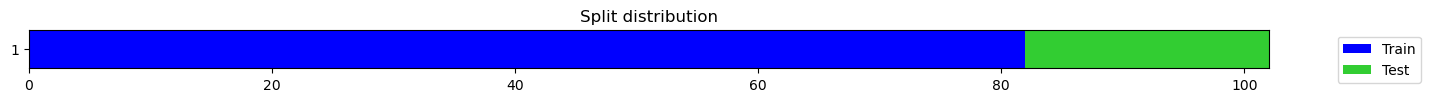

((#82) [0,1,2,3,4,5,6,7,8,9...], (#20) [82,83,84,85,86,87,88,89,90,91...])

In [ ]:
assert config.analysis_mode in ['offline','online'], 'Invalid analysis mode'

X = X_train
print(X.shape)
if config.analysis_mode == 'online':
    splits = TimeSplitter(valid_size=0.2, show_plot=True)(X)
    
elif config.analysis_mode == 'offline':
    splits = get_splits(np.arange(len(X)), valid_size=config.valid_size)
    
splits

## MVP - Encoder training
> Train MVP with optional adaptable window sizes, to allow for inference with different
window sizes, to provide an easier exploration of the embedding space through different
ways of sliding the data.

### Set callback list

In [ ]:
cbs = L(WandbCallback(log_preds=False)) if config.use_wandb else L()

### Set transformations

In [ ]:
tfms = [ToFloat(), None]
batch_tfms = [TSStandardize(by_sample=config.norm_by_sample, 
               use_single_batch=config.norm_use_single_batch)]

### Get data loaders

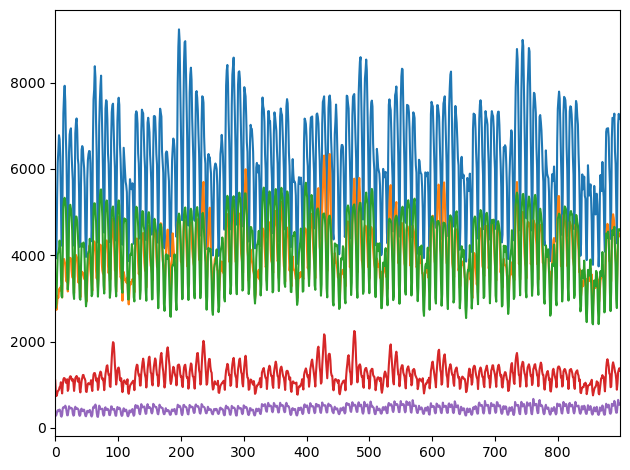

In [ ]:
dls = get_ts_dls(X, splits=splits, tfms=tfms, bs=config.batch_size, batch_tfms=batch_tfms)
dls.show_at(0)

### Build MVP TS Learner

In [ ]:
sgc = ShowGraphCallback2()
learn = ts_learner(dls, InceptionTimePlus, 
                   cbs= cbs + sgc + MVP(
                       r = config.r, 
                        window_size=config.mvp_ws, 
                        future_mask = config.mask_future, 
                        target_dir='./models', 
                        sync = config.mask_sync, 
                        stateful = config.mask_stateful,
                        fname=f'encoder_MVP'
                    ), y_range=[X.min(), X.max()])

### Example mask

#### Create mask

In [ ]:
if config.mask_future:
    example_mask = create_future_mask(torch.from_numpy(X[0]), config.r, sync=config.mask_sync)
else:
    example_mask = create_subsequence_mask(torch.from_numpy(X[0]), config.r, stateful=config.mask_stateful, sync=config.mask_sync)

#### Show mask

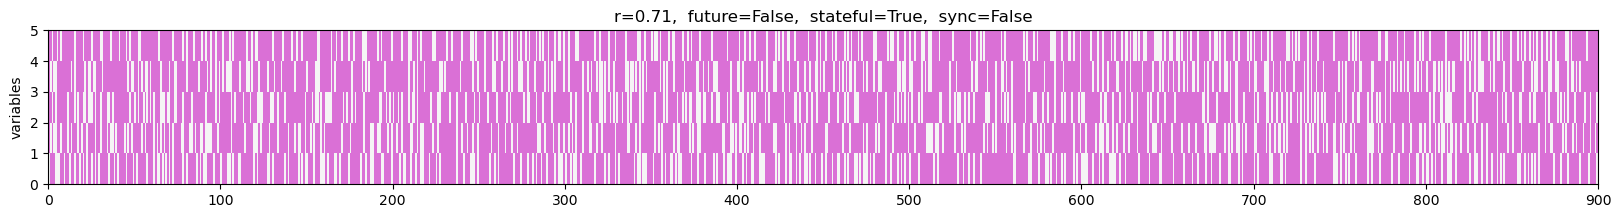

In [ ]:
fig, ax = plt.subplots(figsize=(20, 2))
plt.pcolormesh(example_mask[0], cmap=colors.ListedColormap(['whitesmoke', 'orchid']))
plt.title(f'r={config.r},  future={config.mask_future},  stateful={config.mask_stateful},  sync={config.mask_sync}')
ax.set_ylabel('variables')
plt.show()

 ## Check window size configuration

### Check config attributes

In [ ]:
expected_window_size = config.mvp_ws
print("w", config.w, "mvp_ws", config.mvp_ws)
print("expected ", expected_window_size)


w 900 mvp_ws [450, 900]
expected  [450, 900]


### Check obtained attributes

In [ ]:
mvp_cb = learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0]  # Encuentra el callback MVP
obtained_window_size=mvp_cb.window_size
print("obtained ", obtained_window_size)

obtained  [450, 900]


In [ ]:
if (expected_window_size != obtained_window_size):
    raise ValueError("Obtained window_size for MVP training different from expected window size. Check size, ws1 & ws2 parameters in '02b-encoder_MVP.yaml'")
else: 
    print("Obtained window size tuple is the expected one. Continue!")

Obtained window size tuple is the expected one. Continue!


#### Check w1 < w2 for MVP random window size selection

In [ ]:
if (obtained_window_size[1] < obtained_window_size[0]):
    raise ValueError("Ws2 must be greater than Ws1 as they are the maximun and minimum window size respectively. Please ensure w2 > w1")
else: 
    w_sizes = np.random.randint(obtained_window_size)
    print(w_sizes)

[133 894]


#### Check self.x.shape[-1] for np.random.randint(0, self.x.shape[-1] - ws) MMVP calculus

In [ ]:
#Get data batch
x = next(iter(dls.train))
print("x", x)
x_data=x[0]
print("Data shape: " + str( x_data.shape))
time_serie_len = x_data.shape[-1]
print("Time serie len: " + str( time_serie_len))
#Just in case
for ws in w_sizes:
    diff = time_serie_len - ws
    print("diff time serie len - ws", diff)
    result = np.random.randint(0, diff)
    print("ws ", ws, "diff", diff, "result",  result)

x (TSTensor(samples:82, vars:5, len:900, device=cuda:0, dtype=torch.float32),)
Data shape: torch.Size([82, 5, 900])
Time serie len: 900
diff time serie len - ws 767
ws  133 diff 767 result 130
diff time serie len - ws 6
ws  894 diff 6 result 0


### Train the model

epoch     train_loss  valid_loss  time     
0         1.157645    0.887353    00:00     


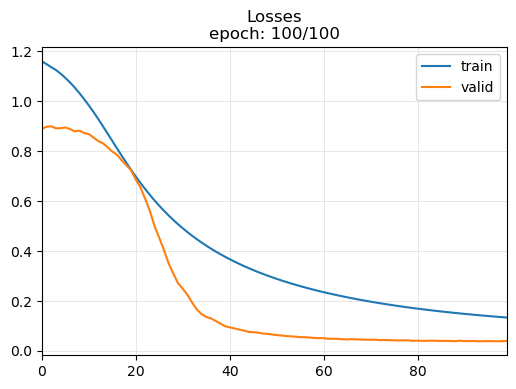

1         1.146158    0.895361    00:00     
2         1.134203    0.897425    00:00     
3         1.122676    0.889378    00:00     
4         1.108159    0.889665    00:00     
5         1.091346    0.892777    00:00     
6         1.072886    0.886246    00:00     
7         1.052455    0.877106    00:00     
8         1.030037    0.879931    00:00     
9         1.006244    0.870677    00:00     
10        0.981144    0.866123    00:00     
11        0.954756    0.852607    00:00     
12        0.926812    0.838138    00:00     
13        0.897862    0.829500    00:00     
14        0.868504    0.813668    00:00     
15        0.838749    0.796456    00:00     
16        0.809137    0.783605    00:00     
17        0.779823    0.761520    00:00     
18        0.751087    0.741488    00:00     
19        0.723171    0.720887    00:00     
20        0.696445    0.684254    00:00     
21        0.670746    0.652866    00:00     
22        0.646222    0.607235    00:00     
23        

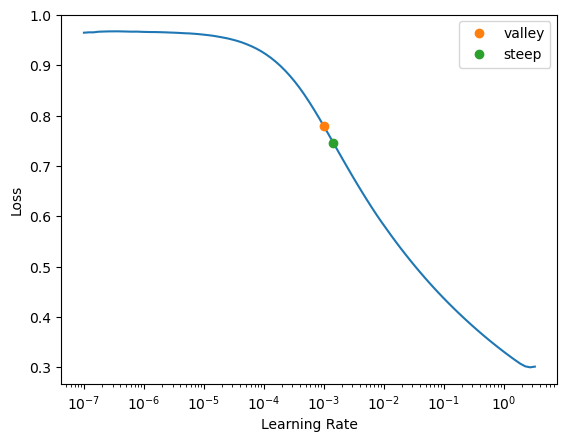

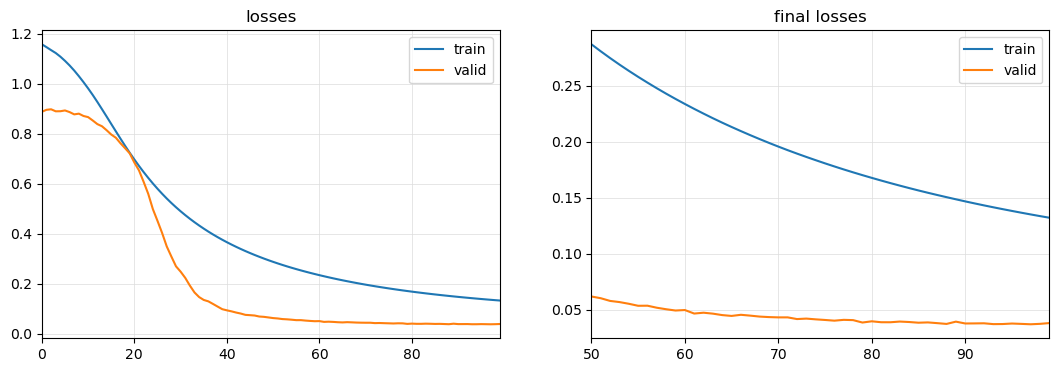

In [ ]:
lr_valley, lr_steep = learn.lr_find(suggest_funcs=(valley, steep))
learn.fit_one_cycle(n_epoch=config.epochs, lr_max=lr_valley,  cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.000001, patience=10)])

#### Validate the model

In [ ]:
learn.validate()

not enough values to plot a chart


(#1) [1.1273949146270752]

## Visualize predictions

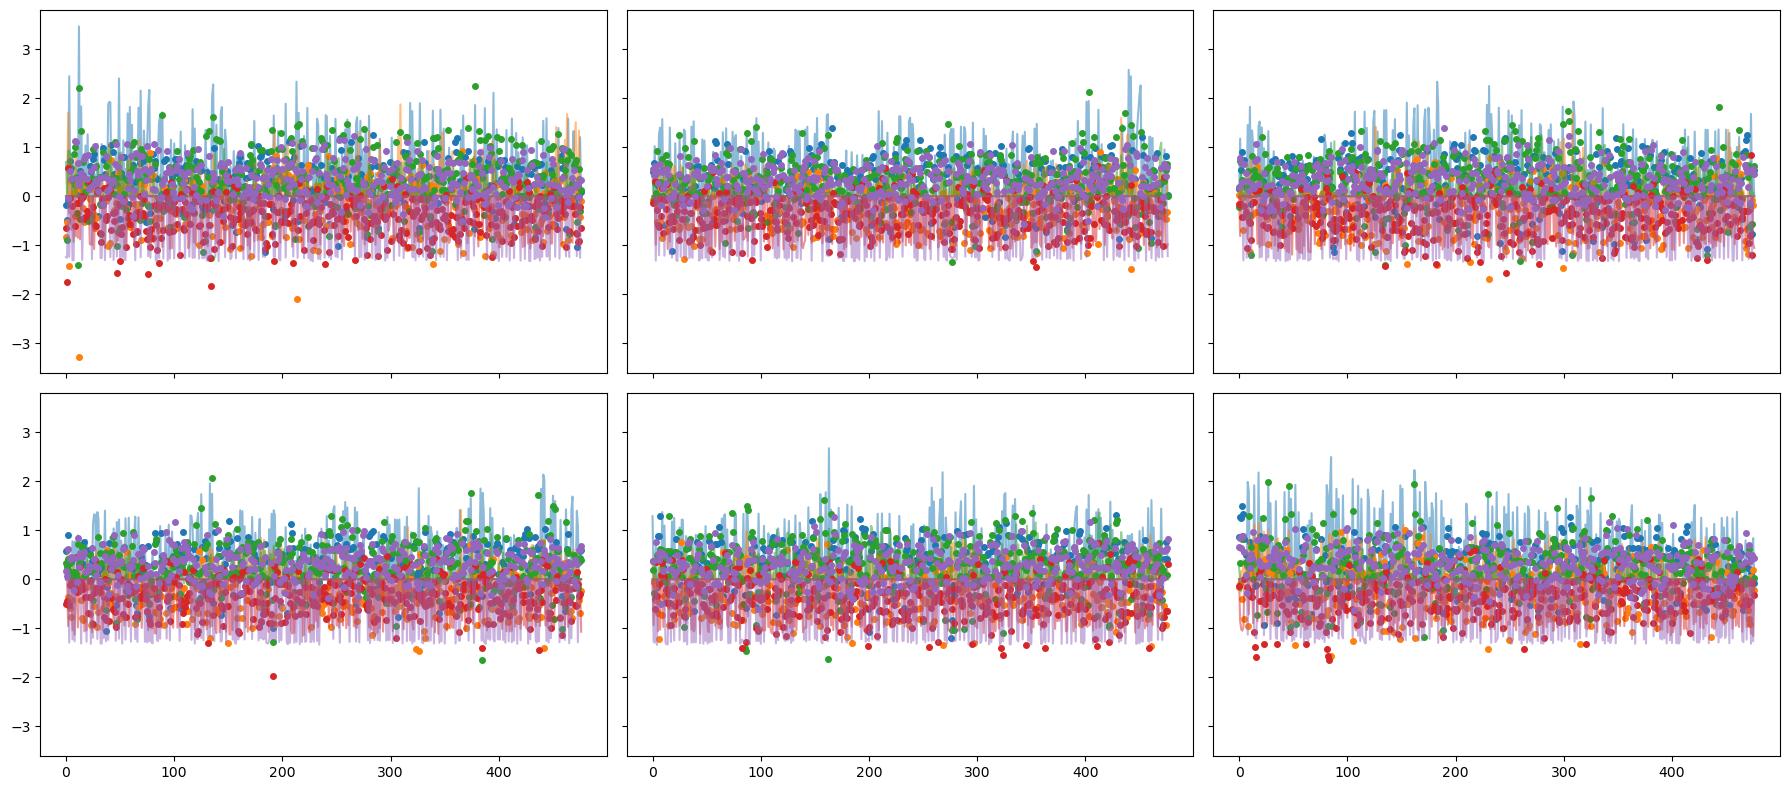

In [ ]:
learn.MVP.show_preds(sharey=True, nrows=2) # error with nwors=1 or ncols=1

## Save artifact to W&B
> Remove extra information and saving the learner object as an weight and biases artifact

In [ ]:
# Remove the ShowGraphCallback2 callback to avoid errors in the frontend (TODO)
learn.remove_cb(sgc)

<fastai.learner.Learner>

In [ ]:
# Log the learner without the datasets
aux_learn = learn.export_and_get()
if config.use_wandb: 
    run.log_artifact(
        ReferenceArtifact(
            aux_learn, 
            f'mvp', 
            type='learner', 
            metadata=dict(run.config)
        ), 
        aliases=config.alias
    )

## Close W&B

In [ ]:
run.finish()

epoch,100
eps_0,1e-05
eps_1,1e-05
lr_0,0.0
lr_1,0.0
mom_0,0.94996
mom_1,0.94996
raw_loss,0.07072
sqr_mom_0,0.99
sqr_mom_1,0.99
train_loss,0.13204


In [ ]:
reset_kernel=True
if reset_kernel:
    import os
    os._exit(00)